## Plot branchwater output
Used branchwater to look for microbes that are common in pig gut. 
Returns metagenomes. Count for each metagenome how many of these microbes are present. 
If more of these microbes (out of 16) are present, is the metagenome likely to be pig? (yes)

In [204]:
# base checkout of workflow directory is here:
BASE='/home/ctbrown/scratch3/2025-workflow-core99/'

# parquet files from branchwater
BASE_OUTPUTS=BASE+'/outputs.branchwater'

# set hash threshold (at a value you want) Im using 1000 
HASH_THRESHOLD=1000

In [205]:
# imports
import polars as pl
import numpy as np
import sklearn.tree
import pandas as pd
import pyarrow
import matplotlib.pyplot as plt

In [206]:
dirpath = BASE_OUTPUTS+'/*.parquet'

bw_df = pl.scan_parquet(dirpath).collect()
bw_df = bw_df.with_columns(pl.col("query_name").alias("species"),
                           pl.col("match_name").alias("acc"))
bw_df = bw_df.select(["species", "acc", "containment", "intersect_hashes"])

# set threshold (in hashes in this case)
bw_df = bw_df.filter(pl.col("intersect_hashes") >= HASH_THRESHOLD)


In [207]:
# get metadata, only compare WGS
metadata_df = (
    pl.scan_parquet("/group/ctbrowngrp5/sra-metagenomes/20241128-metadata.parquet")
    .filter(pl.col("acc") != "NP")
    .filter(pl.col("assay_type") == "WGS")
    .select(["acc", "organism", "bioproject"]) 
    .collect()
)

In [208]:
bw_df = bw_df.join(metadata_df, on="acc", how="left")

In [209]:
# remove shitty entries with shitty metatada
# What is so difficult about adding an ORGANISM TO THIS???? WHO DOES THIS. "metagenome" is NOT INFORMATIVE 
def remove_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
    bad_values = [
        "metagenome",
        "gut metagenome",
        "feces metagenome",
        "manure metagenome",
        "bacterium",
        "unidentified",
        "null"
    ]
    return df.filter(~pl.col("organism").is_in(bad_values))

# group by organism and count number of bacteria per SRA 
def pivot_count(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df
        .group_by(["organism", "count"])
        .len()  # count occurrences
        .pivot(
            values="len",
            index="organism",
            columns="count"
        )
        .fill_null(0)  # optional: fill missing with 0
    )

# set mapping for "categories of interest" I like human v pig v neither. 
category_map_simple = {
    'human associated': ['human', 'homo', 'sapiens'],
    'pig': ['pig', 'sus', 'scrofa']}


# Function to assign category based on keywords above
def get_broad_cat_simple(organism):
    for cat, keywords in category_map_simple.items():
        if any(keyword.lower() in str(organism).lower() for keyword in keywords):
            return cat
    return 'other'  

# grouping data for plotting (either cumulative or infdividually)
def group_for_plot(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_grouped = df.groupby('broad_cat')[numeric_cols].sum().reset_index()
    df_cumulative = df_grouped.copy()
    df_cumulative[numeric_cols] = df_cumulative[numeric_cols].iloc[:, ::-1].cumsum(axis=1).iloc[:, ::-1]
    return df_grouped, df_cumulative

# colormap plotting
colors = {
    'pig': '#264653',
    'human associated': '#e76f51',
    'other': '#f4a261',
    'pig/other': '#2a9d8f',
    'pig-associated': '#e9c46a'
    }

# Plotting in numbers (xx metagenomes)
def plot_cat(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_abs = df.set_index('broad_cat')[numeric_cols]
    ax = df_abs.T.plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        color=[colors[c] for c in df_abs.index]
    )
    ax.set_ylabel('Number of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', loc='upper right')
    plt.tight_layout()


# plot relative percentages (x percent of the metagenomes (total 100%))
def plot_cat_percent(df):
    numeric_cols = sorted(df.select_dtypes(include='number').columns, key=lambda x: int(x))
    df_norm = df.set_index('broad_cat')[numeric_cols].div(df[numeric_cols].sum(axis=0), axis=1) * 100
    ax = df_norm.T.plot(
        kind='bar',
        stacked=True,
        figsize=(6,6),
        color=[colors[c] for c in df_norm.index]
    )
    ax.set_ylabel('Percent of metagenomes')
    ax.set_xlabel('Number of bacteria (out of 16)')
    plt.legend(title='Metagenome origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()


In [210]:
# remove unnanotated metags (metagenome, gut metagenome, etc)
df = remove_unnannotated(bw_df)

# count number of orgs (out of 16) in each mG
counts_df = (
    df
    .group_by(["acc", "organism"])
    .len()
    .rename({"len": "count"})
)

# pivot for plotting
dfp = pivot_count(counts_df)

/tmp/ipykernel_1056465/3663608851.py:21: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  .pivot(


In [211]:
# save then load as pandas bc dont want to rewrite all functions
dfp.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")
dfp =pd.read_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/orgcounts.csv")


In [212]:
# give entries categories (human, pig, other)
dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
df_ind, df_cm = group_for_plot(dfp)

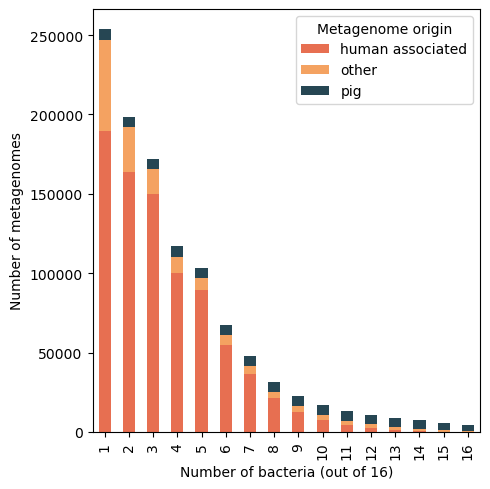

In [213]:
# make chart with absolute of metagenomes (cumulative)
# 1kb threshold
plot_cat(df_cm)

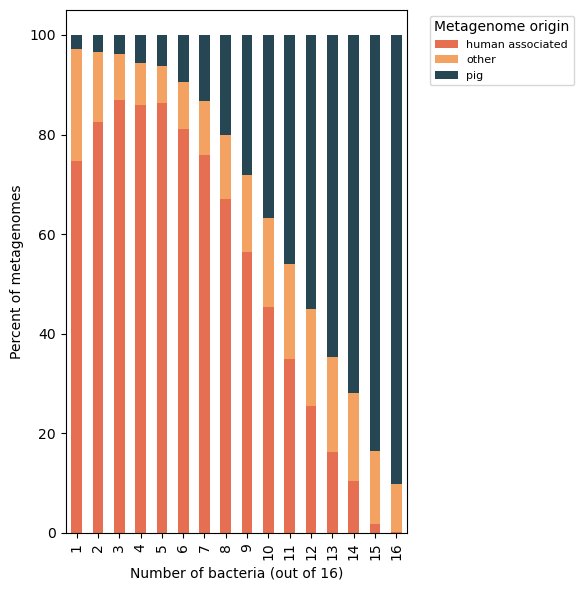

In [214]:
# plot percentage of metagenomes that has x microbial species (cumulative)
plot_cat_percent(df_cm)

## Do some manual curation (not needed rn):
- From annotated ones: Screen the "other" category 
- Esp if > 10 species

In [ ]:
# bw_df.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/bw_df.csv")
# bw_df = pd.read_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/bw_df.csv")

In [ ]:
# man annotation
# df_manual_annotation =pd.read_csv('/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/csv_files/251111_metag_mancur.csv') 


In [ ]:
# # merge mancur with original df
# df2 = bw_df.merge(df_manual_annotation[['bioproject', 'manual_org']], on='bioproject',how='left')
# df2['organism'] = df2['manual_org'].combine_first(df2['organism'])
# df2 = df2.drop(columns=['manual_org'])

# # get counts and whats missing fro mancur to add
# df2['broad_cat'] = df2['organism'].apply(get_broad_cat_simple)
# df2 = df2[['bioproject','organism','broad_cat']].value_counts().to_frame()
# df2.to_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/acc_count_org.formancur2.csv")


In [ ]:
# # change format for df
# def pivot_count(df):
#     df_pivot = pd.crosstab(df['organism'], df['count']).reset_index()
#     df_pivot.columns = ['organism'] + [str(col) for col in df_pivot.columns[1:]]
#     return df_pivot


In [ ]:
# counts_df2 = (
#     df2.groupby(["acc", "organism"])
#       .size()                   # counts the number of rows per group
#       .reset_index(name="count")  # convert Series to DataFrame and name the count column
# )


In [ ]:
# dfp = pivot_count(counts_df2)

# dfp['broad_cat'] = dfp['organism'].apply(get_broad_cat_simple)
# df_ind, df_cm = group_for_plot(dfp)

In [ ]:
# # also for these uninformative ones (at least check )
# def keep_unnannotated(df: pl.DataFrame) -> pl.DataFrame:
#     bad_values = [
#         "metagenome",
#         "gut metagenome",
#         "feces metagenome",
#         "manure metagenome",
#         "bacterium",
#         "unidentified",
#         "null"
#     ]
#     return df.filter(pl.col("organism").is_in(bad_values))

# #keep
# df_unnanotated = keep_unnannotated(bw_df)
# df_unnanotated = (
#     df_unnanotated
#     .group_by(["organism", "bioproject"])
#     .len()
#     .rename({"len": "count"})
# )

# df_unnanotated.write_csv("/group/ctbrowngrp2/amhorst/2025-pig-corespp/results/branchwater/df_unnanotated.formancur.csv")